### Imports

In [6]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns

### Helper functions

In [7]:
def rand_cov(dim, scale=1e-6):
    # Generate a random symmetric matrix
    A = np.random.rand(dim, dim)
    symmetric_matrix = (A + A.T) / 2
    
    # Compute the covariance matrix
    covariance_matrix = np.dot(symmetric_matrix, symmetric_matrix.T)

    # Scale the covariance matrix
    covariance_matrix *= scale
    
    return covariance_matrix

def chol(cov, precision = 1e-12):
  L, d, _ = sp.linalg.ldl(cov)
  d = np.diag(d)
  inds = d >= d.max() * precision
  d = np.sqrt(d[inds])
  Q = np.diag(d) @ L.T[inds,]
  
  return Q

def evar(mu, sigma, alpha, p, q, cum_entry):
  return mu.T @ q + np.sqrt(-2 * np.log(alpha)) * cp.norm(chol(sigma) @ q, 2) - cum_entry

def evar_premium(mu, sigma, alpha, p, q, q_total, cum_entry): 
  return evar(mu, sigma, alpha, p, q_total + q, cum_entry + q.T @ p) - evar(mu, sigma, alpha, p, q_total, cum_entry)

### Optimization

In [8]:
def opt_liq_ratio(init_margin_req, main_margin_req, alpha, collateral, p_entry, p_curr, q, q_total, mu, cov, cum_entry, penalty = 0):

  if (collateral + (q.T @ (p_curr - p_entry)) < 0):
    print("Account already underwater")
    return np.nan

  is_liq = (collateral +  (q.T @ (p_curr - p_entry))) < (np.abs(q).T @ p_curr) * main_margin_req

  if (not is_liq):
    print("Account is not liquidatable")
    return np.nan
    
  n = len(p_entry)

  # Decision variable
  w = cp.Variable(n)

  # Objective function
  objective = cp.Minimize(w.T @ (cp.multiply(p_curr, np.abs(q))))

  # Constraints
  constraints = [
      w >= 0,  # Element-wise lower bound
      w <= 1,  # Element-wise upper bound
      init_margin_req * ((np.ones(n) - w).T @ cp.multiply(p_curr, np.abs(q))) <= collateral - evar_premium(mu, cov, alpha, p_curr, cp.multiply(-w, q), q_total, cum_entry) + q.T @ (p_curr - p_entry) - penalty * w.T @ cp.multiply(np.abs(q), p_curr),
  ]

  # Setup for SOCP
  A = -chol(cov) @ cp.diag(q)
  b = chol(cov) @ q_total
  c = (init_margin_req * cp.multiply(np.abs(q), p_curr) - cp.multiply(q, p_curr - mu) - penalty * cp.multiply(np.abs(q), p_curr)) / np.sqrt(-2 * np.log(alpha))
  d = (-init_margin_req * p_curr.T @ np.abs(q) + collateral + q.T @ (p_curr - p_entry) + np.sqrt(-2 * np.log(alpha)) * cp.norm(chol(cov) @ q_total, 2)) / np.sqrt(-2 * np.log(alpha))
  soc_constraints = [
      w >= 0,
      w <= 1,
      cp.SOC(c.T @ w + d, A @ w + b)
  ]

  # Define the problem
  problem = cp.Problem(objective, constraints)
  # problem = cp.Problem(objective, soc_constraints)

  # Solve the problem
  result = problem.solve()

  # Need to fully liquidate 
  if problem.status == "infeasible":
    weights = np.ones(n)
  else:
    weights = w.value
  
  # Round down/up weights that are approximately 0/1
  weights = np.minimum(np.maximum(weights, 0), 1) * (q != 0)
  weights = weights * (weights > 1e-12)
  weights = 1 - (1 - weights) * ((1 - weights) > 1e-12)

  # Print results
  print("Status: ", "Partially Liquidated" if problem.status == "optimal" else "Fully Liquidated")
  print(f"Optimal notional amount liquidated: ${result:.2f} ({(100 * result) / (p_curr.T @ np.abs(q)):.2f}%) \n")

  pos_val_pre = p_curr.T @ np.abs(q)
  print(f"Positions value prior: ${pos_val_pre:.2f}")
  acc_val_pre = collateral  + q.T @ (p_curr - p_entry)
  print(f"Account value prior: ${acc_val_pre:.2f}") 
  print(f"Margin ratio prior: {100 * acc_val_pre / pos_val_pre:.2f}% \n")

  pos_val_post = (1 - weights).T @ np.multiply(np.abs(q), p_curr)
  print(f"Positions value post: ${pos_val_post:.2f}")
  premium = evar_premium(mu, cov, alpha, p_curr, cp.multiply(-weights, q), q_total, cum_entry).value
  print(f"Premium paid: ${premium:.2f}")
  print(f"Penalty collected: ${penalty * weights @ (np.abs(q) * p_curr):.2f}")
  acc_val_post = collateral - premium + q.T @ (p_curr - p_entry) - penalty * weights @ (np.abs(q) * p_curr)
  print(f"Account value post: ${acc_val_post:.2f}")
  print(f"Margin ratio post: {100 * acc_val_post / pos_val_post if pos_val_post > 0 else 0:.2f}%")

  return weights, premium

### Example

In [9]:
init_margin_req = 0.05 
main_margin_req = 0.025
alpha = 0.005
collateral = 1300
p_entry = np.array([90, 190, 320, 280, 30])  # Entry
p_curr = np.array([70, 150, 300, 200, 10])  # Given vector p LLWWL
q = np.array([20, 30, -10, -5, 10])  # Given vector q
q_total = np.array([-10, -5, 0, 10, 20])  # Given vector q_total
cum_entry = q_total.T @ p_entry 
cov = rand_cov(len(p_entry))  # Given covariance matrix

_ = opt_liq_ratio(init_margin_req, main_margin_req, alpha, collateral, p_entry, p_curr, q, q_total, p_curr, cov, cum_entry)

Status:  Partially Liquidated
Optimal notional amount liquidated: $7999.54 (80.00%) 

Positions value prior: $10000.00
Account value prior: $100.00
Margin ratio prior: 1.00% 

Positions value post: $2000.46
Premium paid: $-0.02
Penalty collected: $0.00
Account value post: $100.02
Margin ratio post: 5.00%


### Example with real data

In [ ]:
prices = pd.read_csv('data/prices.csv')
sigmas = pd.read_csv('data/mus.csv')
sigmas = pd.read_csv('data/sigmas.csv')

Status:  Partially Liquidated
Optimal notional amount liquidated: $1600.31 (46.78%) 

Positions value prior: $3421.22
Account value prior: $68.72
Margin ratio prior: 2.01% 

Positions value post: $1820.91
Premium paid: $-22.32
Penalty collected: $0.00
Account value post: $91.05
Margin ratio post: 5.00%


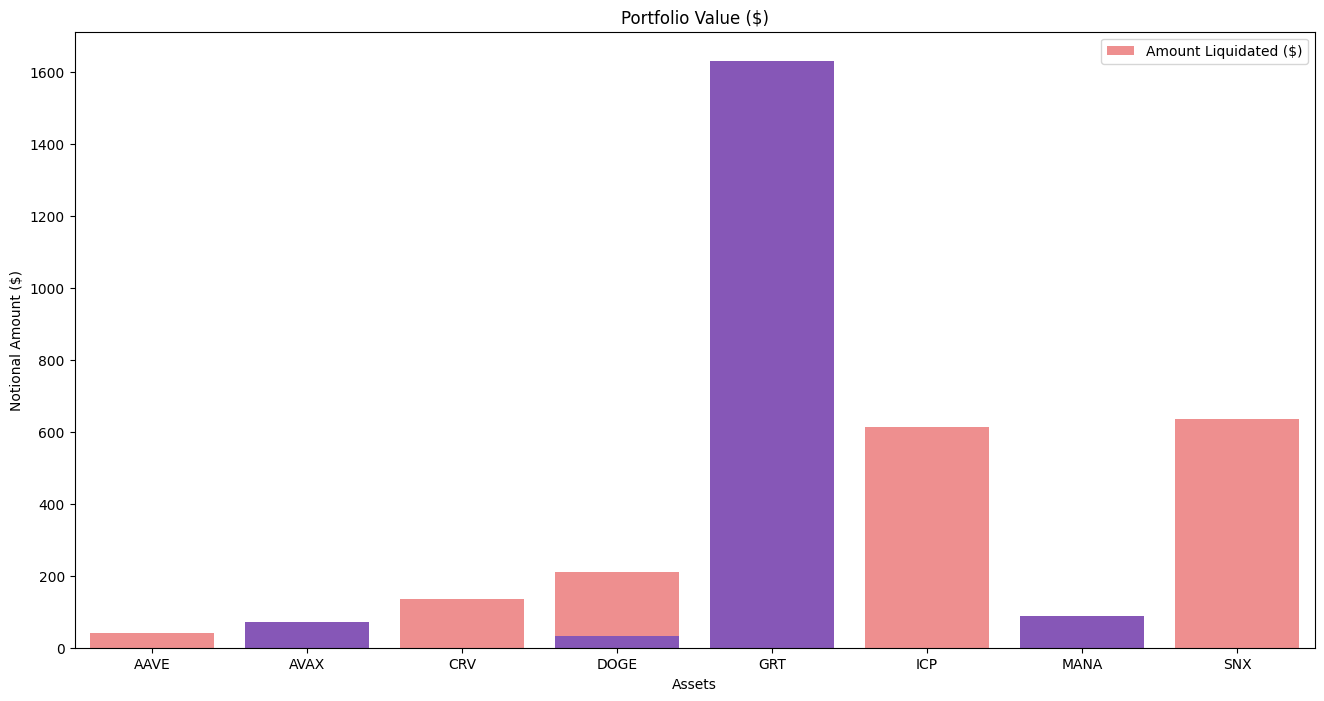

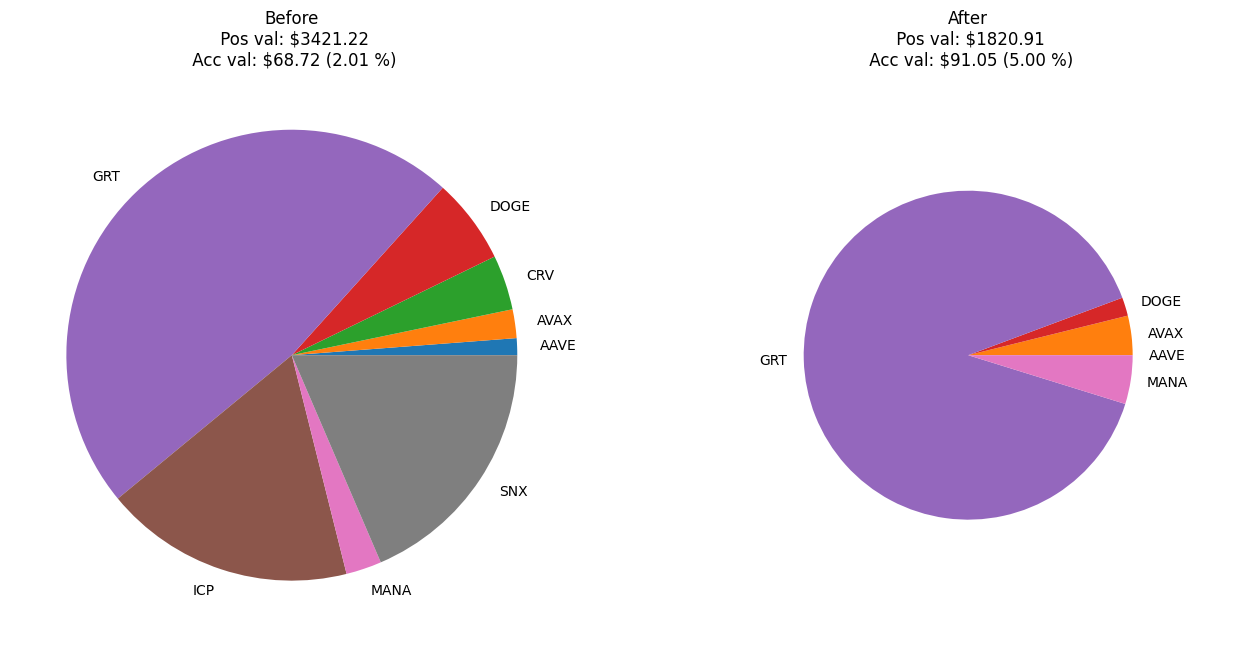

In [34]:
init_margin_req = 0.05 
main_margin_req = 0.025
alpha = 0.01
penalty = 0

p_entry = prices.iloc[0,].to_numpy()
p_curr = prices.iloc[1440,].to_numpy()
price_mu = mus.iloc[:, 1440].to_numpy()
price_sigma = sigmas.iloc[:, 1440].to_numpy().reshape((prices.shape[1], prices.shape[1]))
n = len(p_entry)
open_trade = np.random.binomial(1, 0.2, n)
sign = np.random.binomial(1, 0.5, n) * 2 - 1
size = np.random.exponential(1, n) * np.divide(np.repeat(1000, n), p_entry)
sign_total = np.random.binomial(1, 0.5, n) * 2 - 1
size_total = np.random.exponential(1, n) * np.divide(np.repeat(10000, n), p_curr)

q = open_trade * sign * size
assets = [x.split('.')[0] for x in prices.columns[q != 0]]
collateral = np.random.uniform(0.5, 0.99, 1) * main_margin_req * abs(q).T @ p_curr - q.T @ (p_curr - p_entry)

q_total = sign_total * size_total
cum_entry = q_total.T @ p_entry

w, premium = opt_liq_ratio(init_margin_req, main_margin_req, alpha, collateral, p_entry, p_curr, q, q_total, price_mu, price_sigma, cum_entry, penalty = penalty)

_, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.barplot(data = pd.DataFrame({'Assets': assets, 'Notional Amount ($)': (p_curr * abs(q))[q != 0]}), x = 'Assets', y = 'Notional Amount ($)', label='Amount Liquidated ($)', color="red", alpha = 0.5)
sns.barplot(data = pd.DataFrame({'Assets': assets, 'Notional Amount ($)': (p_curr * (1 - w) * np.abs(q))[q != 0]}), x = 'Assets', y = 'Notional Amount ($)', color="blue", alpha = 0.5, )
ax.set(title="Portfolio Value ($)")
ax.legend()
_, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].pie((p_curr * np.abs(q))[q != 0], labels = assets)
axes[0].set(title = f"Before\n Pos val: ${p_curr.T @ np.abs(q):.2f}\n Acc val: ${collateral + q.T @ (p_curr - p_entry):.2f} ({100 * (collateral + q.T @ (p_curr - p_entry)) / (p_curr.T @ np.abs(q)):.2f} %)")
acc_after = collateral - premium + q.T @ (p_curr - p_entry) - penalty * p_curr @ (w * np.abs(q))
axes[1].pie((p_curr * (1 - w) * np.abs(q))[q != 0], radius = np.sqrt(p_curr.T @ ((1 - w) * np.abs(q)) / (p_curr.T @ np.abs(q))), labels = [x if (w[q != 0])[i] != 1 else None for (i, x) in enumerate(assets)])
axes[1].set(title = f"After\n Pos val: ${p_curr.T @ ((1 - w) * np.abs(q)):.2f}\n Acc val: ${acc_after:.2f} ({100 * acc_after / (p_curr.T @ ((1 - w) * np.abs(q))):.2f} %)")
plt.show()